In [1]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from sklearn.manifold import TSNE
import plotly_express as px

In [2]:
class W2VExplorer:
    
    w2v_min_count:int = 10
    w2v_workers:int = 4
    w2v_size:int = 256
    w2v_window:int = 2
    tsne_perplexity:int = 40
    tsne_n_components:int = 2
    tsne_init:str = 'pca'
    tsne_n_iter:int = 2500
    tsne_random_state:int = 23
        
    
    def __init__(self, tokens, bag):
        self.TOKENS:pd.DataFrame = tokens
        self.BAG = bag
        
    def generate_model(self):
        print("Bag:", self.BAG[-1])
        print('Getting DOCS')
        self._get_docs()
        print("Getting MODEL")
        self._get_model()
        print("Getting tSNE Coords")
        self._get_tsne_coords()
        print(u'\u2713')
        return self
        
    def _get_docs(self):
        """Create a list of documents for Gensim"""
        self.DOCS = self.TOKENS.groupby(self.BAG)\
            .term_str.apply(lambda  x:  x.tolist())\
            .reset_index()['term_str'].tolist()
        
    def _get_model(self):
        """Run word2vec again the docs"""
        self.model = word2vec.Word2Vec(self.DOCS, 
                                 vector_size = self.w2v_size, 
                                 window = self.w2v_window, 
                                 min_count = self.w2v_min_count, 
                                 workers = self.w2v_workers)

    def _get_tsne_coords(self):
        # self.coords = pd.DataFrame(index=range(len(self.model.wv.vocab))) # Gensim 3
        self.coords = pd.DataFrame(index=range(len(self.model.wv)))
        # self.coords['label'] = [w for w in self.model.wv.vocab] # Gensim 3
        self.coords['label'] = [w for w in self.model.wv.key_to_index]
        self.coords['vector'] = self.coords['label'].apply(lambda x: self.model.wv.get_vector(x))
        self.tsne_model = TSNE(perplexity = 40, 
                               n_components = self.tsne_n_components, 
                               init = self.tsne_init, 
                               n_iter = self.tsne_n_iter, 
                               random_state = self.tsne_random_state)
        # self.tsne_values = self.tsne_model.fit_transform(self.coords['vector'].tolist())
        self.tsne_values = self.tsne_model.fit_transform(np.array(self.coords['vector'].to_list()))
        self.coords['x'] = self.tsne_values[:,0]
        self.coords['y'] = self.tsne_values[:,1]
        
    def plot_tsne(self):
        px.scatter(self.coords, 'x', 'y', text='label', height=1000)\
            .update_traces(mode='text').show()
        
    def complete_analogy(self, A, B, C, n=2):
        try:
            cols = ['term', 'sim']
            return pd.DataFrame(self.model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
        except KeyError as e:
            print('Error:', e)
            return None

    def get_most_similar(self, positive, negative=None):
        return pd.DataFrame(self.model.wv.most_similar(positive, negative), columns=['term', 'sim']) 

In [3]:
TOKENS = pd.read_csv("data/CORPUS.csv").set_index(['book_num', 'chap_num'])

In [4]:
w2v = W2VExplorer(TOKENS, ['book_num', 'chap_num'])

In [5]:
w2v.generate_model()

Bag: chap_num
Getting DOCS
Getting MODEL
Getting tSNE Coords
✓


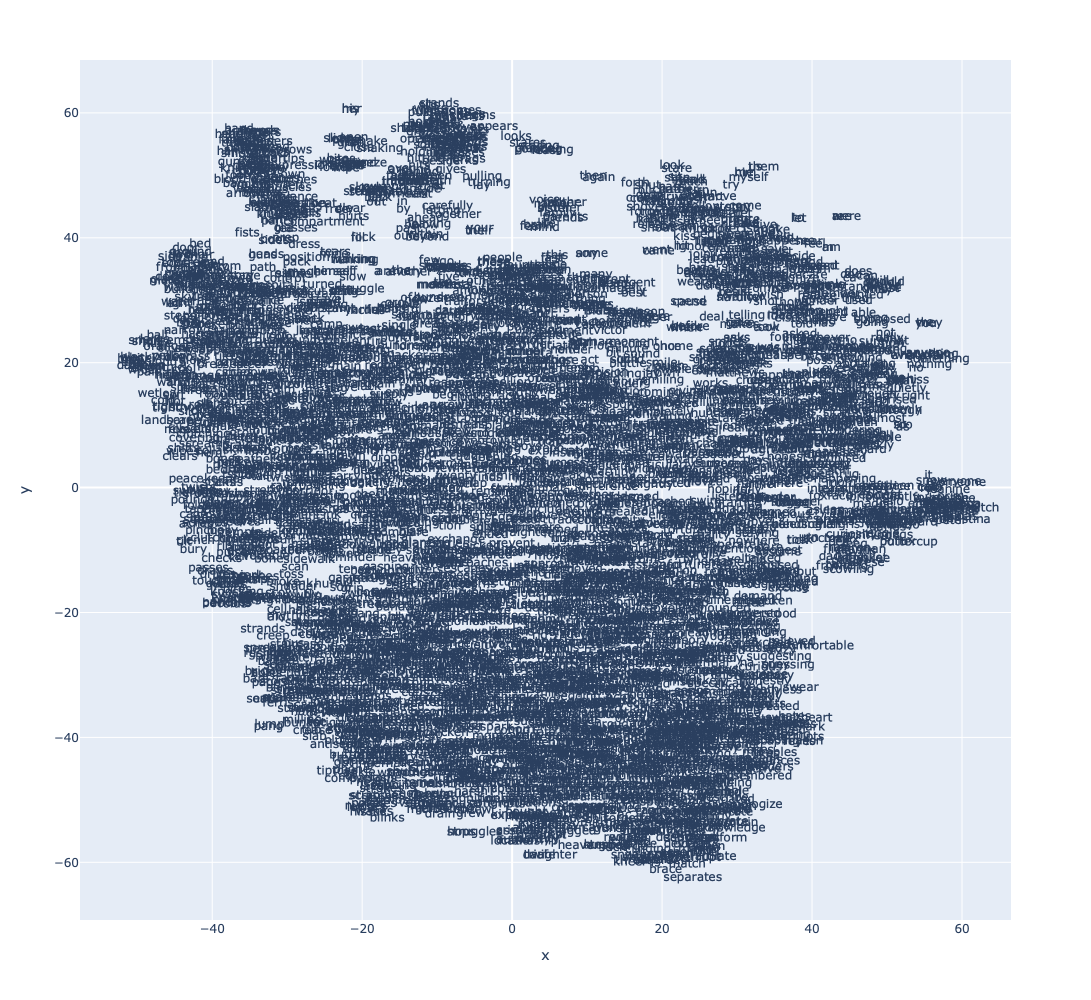

In [6]:
w2v.plot_tsne()

In [9]:
def get_vector(row):
    w = row.name
    try:
        vec = w2v.model.wv[w]
    except KeyError as e:
        vec = None
    return vec

In [14]:
VOCAB = pd.read_csv("data/VOCAB.csv").set_index('term_str')

In [15]:
WV = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)

In [16]:
WV

0         1         2         3         4         5    \
term_str                                                               
00        0.006559 -0.135996  0.028109  0.117380  0.079450 -0.023739   
1         0.053639 -0.175376  0.028189  0.177775  0.182465 -0.036611   
7        -0.012935 -0.143686 -0.011750  0.115489  0.097156 -0.006921   
a        -0.956843 -0.522762  0.090682  0.052552  0.560957 -0.085978   
abandon  -0.009341 -0.102747 -0.013638  0.077255  0.076393 -0.020224   
...            ...       ...       ...       ...       ...       ...   
yours     0.057661 -0.101599  0.037267  0.075801  0.071881 -0.020567   
yourself  0.013713 -0.319144  0.283850 -0.008932  0.236162 -0.115189   
zeke      0.332351 -0.173471  0.217558  0.509899  0.341165  0.072566   
zip      -0.062743 -0.135583 -0.024861  0.203947  0.090613 -0.009959   
zoe       0.126106 -0.119653  0.149877  0.187602  0.157169  0.001408   

               6         7         8         9    ...       246       247  \
term_str                                          ...                       
00       -0.002172 -0.059967 -0.038984  0.083559  ...  0.071168 -0.010835   
1        -0.025897 -0.083480 -0.011450  0.139654  ...  0.138316  0.015763   
7         0.015870 -0.077134 -0.034705  0.078233  ...  0.085777  0.006548   
a        -0.065031 -0.063129 -0.205353  0.683872  ...  0.110162  0.023745   
abandon  -0.001193 -0.047156 -0.037804  0.066999  ...  0.088903  0.001304   
...            ...       ...       ...       ...  ...       ...       ...   
yours     0.007978 -0.081494 -0.004312  0.093795  ...  0.079311 -0.005830   
yourself -0.046117 -0.056897 -0.091673  0.333796  ...  0.124039 -0.141039   
zeke     -0.054873 -0.050064  0.127045  0.154588  ...  0.165126  0.104574   
zip       0.004253 -0.039087 -0.047549  0.088553  ...  0.146431  0.054880   
zoe      -0.045642 -0.059482  0.020717  0.178729  ...  0.140189  0.001004   

               248       249       250       251       252       253  \
term_str                                                               
00       -0.061985 -0.017402 -0.100035  0.096078 -0.036278 -0.086944   
1        -0.105286 -0.022094 -0.110900  0.146838 -0.056297 -0.097903   
7        -0.071135 -0.020411 -0.083160  0.084884 -0.055443 -0.055310   
a         0.241753 -0.433334  0.132619  0.454060  0.031899 -0.566918   
abandon  -0.031492 -0.016485 -0.061943  0.056899 -0.026315 -0.045481   
...            ...       ...       ...       ...       ...       ...   
yours    -0.115747 -0.050573 -0.133696  0.092834 -0.059894 -0.096765   
yourself -0.213193  0.084742 -0.098798  0.168669 -0.170276 -0.260408   
zeke     -0.173479 -0.020888 -0.304018  0.176222  0.108506 -0.238892   
zip      -0.024188 -0.049990 -0.084272  0.065059 -0.046138 -0.069701   
zoe      -0.195066 -0.064686 -0.204817  0.171769 -0.012923 -0.202743   

               254       255  
term_str                      
00       -0.103575  0.027851  
1        -0.119590  0.028531  
7        -0.108337  0.019628  
a        -0.565091  0.239904  
abandon  -0.087292  0.014449  
...            ...       ...  
yours    -0.088146  0.015230  
yourself  0.014128 -0.132872  
zeke     -0.047050  0.070784  
zip      -0.148762  0.043967  
zoe      -0.090883  0.040715  

[3922 rows x 256 columns]

In [17]:
WV.to_csv("data/VOCAB_W2V.csv")